In [1]:
# Core libraries
import os
import joblib

# Numerical and scientific computation
import numpy as np
import pandas as pd

# Signal processing
from scipy.signal import welch
from scipy.fft import fft
from scipy.stats import entropy, skew, kurtosis

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Visualization
import matplotlib.pyplot as plt

# Wavelet transform
import pywt

# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score


In [ ]:
# in data preprocessing stage I had more than 50 % of data as rest, because of which
# I faced problem of Over Fitting.
# So I removed 90 % of rest data points (systematically , not rendom).

In [2]:
data_path = "../data/combined_sEMG_data_without_extra_rest.csv"

In [3]:
data = pd.read_csv(data_path)

In [4]:
# complete_data = pd.read_csv(data_path)
complete_data = data

In [5]:
data.head()

,muscle_1,muscle_2,muscle_3,muscle_4,subject_id,activity_id,cycle_id
0,-0.008538,-0.022824,0.008150,0.005416,1,1,1
1,-0.007186,-0.015051,-0.001013,0.004787,1,1,1
2,-0.010870,-0.011460,-0.011223,0.003596,1,1,1
3,-0.016778,-0.006743,-0.018296,0.001529,1,1,1
4,-0.022614,0.001419,-0.018439,-0.001502,1,1,1


In [ ]:
data.shape

----

-----

In [30]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, entropy
from scipy.fft import fft
import pywt

# Function to extract time-domain features of 1 segment of data (500 data points at once).
def extract_time_features(segment):
    time_features = []
    feature_names = []
    for col in ['muscle_1', 'muscle_2', 'muscle_3', 'muscle_4']:
        signal = segment[col].to_numpy()
        mean = np.mean(signal)
        median = np.median(signal)
        rms = np.sqrt(np.mean(signal**2))
        mav = np.mean(np.abs(signal))
        wl = np.sum(np.abs(np.diff(signal)))
        zcr = np.sum(np.diff(np.sign(signal)) != 0)
        wamp = np.max(signal) - np.min(signal)
        aac = np.mean(np.abs(np.diff(signal)))
        logd = np.mean(np.log(np.abs(signal) + 1))
        ssi = np.sum(np.diff(np.sign(np.diff(signal))) != 0)
        iemg = np.sum(np.abs(signal))
        se = np.mean(np.abs(np.diff(signal)))
        variance = np.var(signal)
        skewness = skew(signal) if variance > 0 else 0
        kurt = kurtosis(signal) if variance > 0 else 0
        
        time_features.extend([mean, median, rms, mav, wl, zcr, wamp, aac, logd, ssi, iemg, se, variance, skewness, kurt])
        feature_names.extend([
            f"{col}_mean", f"{col}_median", f"{col}_rms", f"{col}_mav", f"{col}_wl", f"{col}_zcr",
            f"{col}_wamp", f"{col}_aac", f"{col}_logd", f"{col}_ssi", f"{col}_iemg", f"{col}_se",
            f"{col}_variance", f"{col}_skewness", f"{col}_kurtosis"
        ])
    return time_features, feature_names

# Function to extract frequency-domain features
def extract_fft_features(segment):
    fft_features = []
    feature_names = []
    for col in ['muscle_1', 'muscle_2', 'muscle_3', 'muscle_4']:
        signal = segment[col].to_numpy()
        fft_vals = np.abs(fft(signal))[:len(signal) // 2]
        freqs = np.fft.fftfreq(len(signal), d=1/2000)[:len(signal) // 2]

        mean_fft = np.mean(fft_vals)
        std_fft = np.std(fft_vals)
        max_fft = np.max(fft_vals)
        min_fft = np.min(fft_vals)
        energy = np.sum(fft_vals**2)
        spectral_entropy = -np.sum((fft_vals / np.sum(fft_vals)) * np.log(fft_vals / np.sum(fft_vals) + 1e-10))
        dominant_freq = freqs[np.argmax(fft_vals)]
        spectral_centroid = np.sum(freqs * fft_vals) / np.sum(fft_vals)
        spectral_spread = np.sqrt(np.sum(((freqs - spectral_centroid) ** 2) * fft_vals) / np.sum(fft_vals))
        skewness = skew(fft_vals)
        kurt = kurtosis(fft_vals)

        fft_features.extend([mean_fft, std_fft, max_fft, min_fft, energy, spectral_entropy,
                             dominant_freq, spectral_centroid, spectral_spread, skewness, kurt])
        feature_names.extend([
            f"{col}_fft_mean", f"{col}_fft_std", f"{col}_fft_max", f"{col}_fft_min", f"{col}_fft_energy",
            f"{col}_fft_entropy", f"{col}_fft_dominant_freq", f"{col}_fft_centroid", f"{col}_fft_spread",
            f"{col}_fft_skewness", f"{col}_fft_kurtosis"
        ])
    return fft_features, feature_names

# Function to extract wavelet-domain features
def extract_wavelet_features(segment, wavelet_name='coif1', levels=5):
    wavelet_features = []
    feature_names = []
    for col in ['muscle_1', 'muscle_2', 'muscle_3', 'muscle_4']:
        signal = segment[col].to_numpy()
        coeffs = pywt.wavedec(signal, wavelet_name, level=levels)
        for i, coeff in enumerate(coeffs):
            # Basic statistical features
            mean = np.mean(coeff)
            std = np.std(coeff)
            var = np.var(coeff)
            ent = entropy(np.abs(coeff))
            max_val = np.max(coeff)
            min_val = np.min(coeff)
            median = np.median(coeff)
            rms = np.sqrt(np.mean(coeff**2))
            energy = np.sum(coeff**2)  # Signal energy
            skewness = skew(coeff)
            kurt = kurtosis(coeff)
            abs_sum = np.sum(np.abs(coeff))  # Integrated absolute value
            wl = np.sum(np.abs(np.diff(coeff)))  # Waveform length
            zcr = np.sum(np.diff(np.sign(coeff)) != 0)  # Zero crossing rate
            
            # Add these features to the wavelet_features list
            wavelet_features.extend([
                mean, std, var, ent, max_val, min_val, median, rms, energy,
                skewness, kurt, abs_sum, wl, zcr
            ])
            
            # Extend feature names for clarity
            feature_names.extend([
                f"{col}_wavelet_level_{i}_mean", f"{col}_wavelet_level_{i}_std",
                f"{col}_wavelet_level_{i}_var", f"{col}_wavelet_level_{i}_entropy",
                f"{col}_wavelet_level_{i}_max", f"{col}_wavelet_level_{i}_min",
                f"{col}_wavelet_level_{i}_median", f"{col}_wavelet_level_{i}_rms",
                f"{col}_wavelet_level_{i}_energy", f"{col}_wavelet_level_{i}_skewness",
                f"{col}_wavelet_level_{i}_kurtosis", f"{col}_wavelet_level_{i}_abs_sum",
                f"{col}_wavelet_level_{i}_waveform_length", f"{col}_wavelet_level_{i}_zcr"
            ])
    return wavelet_features, feature_names


In [31]:
# # Main feature extraction
# window_size = 1000  # 0.5 seconds * 2000 Hz
# overlap = 250  # 25% overlap
# features_list = []
# targets = []
# cycles = []
# columns = []

# for subject_id in data['subject_id'].unique():
#     for cycle_id in data['cycle_id'].unique():
#         cycle_data = data[(data['subject_id'] == subject_id) & (data['cycle_id'] == cycle_id)]
#         for start in range(0, len(cycle_data) - window_size + 1, window_size - overlap):
#             segment = cycle_data.iloc[start:start + window_size]
#             if len(segment) < window_size:
#                 print("len(segment) < window_size")
#                 continue
#             time_features, time_feature_names = extract_time_features(segment)
#             freq_features, freq_feature_names = extract_fft_features(segment)
#             wavelet_features, wavelet_feature_names = extract_wavelet_features(segment)

#             combined_features = time_features + freq_features + wavelet_features
#             if not columns:  # Assign feature names once
#                 columns = time_feature_names + freq_feature_names + wavelet_feature_names
            
#             features_list.append(combined_features)
#             targets.append(segment['activity_id'].iloc[0])
#             cycles.append(segment['cycle_id'].iloc[0])

# # Create DataFrame
# feature_df = pd.DataFrame(features_list, columns=columns)
# feature_df['activity_id'] = targets
# feature_df['cycle_id'] = cycles

/var/folders/79/2vtgx8nd2x59zzcqv_ncq8m00000gn/T/ipykernel_7681/3680086172.py:26: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(signal) if variance > 0 else 0
/var/folders/79/2vtgx8nd2x59zzcqv_ncq8m00000gn/T/ipykernel_7681/3680086172.py:27: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(signal) if variance > 0 else 0
/var/folders/79/2vtgx8nd2x59zzcqv_ncq8m00000gn/T/ipykernel_7681/3680086172.py:85: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(coeff)
/var/folders/79/2vtgx8nd2x59zzcqv_ncq8m00000gn/T/ipykernel_7681/3680086172.py:86: RuntimeWarning: Precision loss occur

In [ ]:
# Read the DataFrame from the CSV file
import pandas as pd

feature_df = pd.read_csv('./final_time_domain_fft_wavelet_stastical_features_1000_250_40subs.csv')

In [32]:
feature_df

,muscle_1_mean,muscle_1_median,muscle_1_rms,muscle_1_mav,muscle_1_wl,muscle_1_zcr,muscle_1_wamp,muscle_1_aac,muscle_1_logd,muscle_1_ssi,...,muscle_4_wavelet_level_5_median,muscle_4_wavelet_level_5_rms,muscle_4_wavelet_level_5_energy,muscle_4_wavelet_level_5_skewness,muscle_4_wavelet_level_5_kurtosis,muscle_4_wavelet_level_5_abs_sum,muscle_4_wavelet_level_5_waveform_length,muscle_4_wavelet_level_5_zcr,activity_id,cycle_id
0,0.000099,0.000822,0.030228,0.021761,8.613201,114,0.237519,0.008622,0.021322,211,...,0.000066,0.001222,0.000749,-0.853446,7.446621,0.417394,0.581182,235,1,1
1,-0.000241,0.000995,0.025578,0.019688,7.820304,116,0.206147,0.007828,0.019371,222,...,0.000001,0.001073,0.000578,-0.506459,5.004082,0.364582,0.492136,232,1,1
2,0.000155,0.000422,0.028064,0.022046,8.402600,124,0.167535,0.008411,0.021664,204,...,0.000042,0.001109,0.000618,-0.708341,6.361614,0.363733,0.512816,242,1,1
3,-0.000076,0.000957,0.025809,0.019704,7.675642,120,0.180043,0.007683,0.019381,211,...,0.000028,0.000856,0.000368,-0.752806,5.436700,0.279479,0.405016,246,1,1
4,-0.000843,0.000425,0.028020,0.020596,7.988726,118,0.249505,0.007997,0.020218,218,...,0.000007,0.000893,0.000400,-0.378905,5.749440,0.288698,0.424437,247,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31795,-0.000151,-0.001637,0.037032,0.028464,14.613098,154,0.247905,0.014628,0.027807,250,...,0.000016,0.000493,0.000122,-0.280028,1.645606,0.180078,0.266012,274,10,5
31796,0.000808,0.000345,0.037353,0.028798,14.194247,167,0.238372,0.014208,0.028128,251,...,0.000011,0.000436,0.000095,-0.226462,0.800275,0.168110,0.249063,265,10,5
31797,0.000133,-0.001041,0.033897,0.024877,12.176928,148,0.268254,0.012189,0.024326,246,...,0.000003,0.000504,0.000128,-0.166632,0.511613,0.196714,0.283718,266,10,5
31798,0.000316,0.000193,0.038018,0.028840,13.550572,148,0.288329,0.013564,0.028149,231,...,0.000003,0.000489,0.000120,-0.054281,1.446314,0.184117,0.272110,260,10,5


In [57]:
# Total rows and number of subjects
total_rows = 31800
rows_per_subject = 795
num_subjects = 40

# Generate the subject_id column
subject_id = np.repeat(np.arange(1, num_subjects + 1), rows_per_subject)

# Ensure the length matches total rows (in case there's any discrepancy)
assert len(subject_id) == total_rows, "Mismatch in total rows and generated subject IDs."

# Add to feature_df
feature_df['subject_id'] = subject_id

# Verify
print(feature_df.head())
print(feature_df.tail())

   muscle_1_mean  muscle_1_median  muscle_1_rms  muscle_1_mav  muscle_1_wl  \
0       0.000099         0.000822      0.030228      0.021761     8.613201   
1      -0.000241         0.000995      0.025578      0.019688     7.820304   
2       0.000155         0.000422      0.028064      0.022046     8.402600   
3      -0.000076         0.000957      0.025809      0.019704     7.675642   
4      -0.000843         0.000425      0.028020      0.020596     7.988726   

   muscle_1_zcr  muscle_1_wamp  muscle_1_aac  muscle_1_logd  muscle_1_ssi  \
0           114       0.237519      0.008622       0.021322           211   
1           116       0.206147      0.007828       0.019371           222   
2           124       0.167535      0.008411       0.021664           204   
3           120       0.180043      0.007683       0.019381           211   
4           118       0.249505      0.007997       0.020218           218   

   ...  muscle_4_wavelet_level_5_rms  muscle_4_wavelet_level_5_energ

In [58]:
feature_df

,muscle_1_mean,muscle_1_median,muscle_1_rms,muscle_1_mav,muscle_1_wl,muscle_1_zcr,muscle_1_wamp,muscle_1_aac,muscle_1_logd,muscle_1_ssi,...,muscle_4_wavelet_level_5_rms,muscle_4_wavelet_level_5_energy,muscle_4_wavelet_level_5_skewness,muscle_4_wavelet_level_5_kurtosis,muscle_4_wavelet_level_5_abs_sum,muscle_4_wavelet_level_5_waveform_length,muscle_4_wavelet_level_5_zcr,activity_id,cycle_id,subject_id
0,0.000099,0.000822,0.030228,0.021761,8.613201,114,0.237519,0.008622,0.021322,211,...,0.001222,0.000749,-0.853446,7.446621,0.417394,0.581182,235,1,1,1
1,-0.000241,0.000995,0.025578,0.019688,7.820304,116,0.206147,0.007828,0.019371,222,...,0.001073,0.000578,-0.506459,5.004082,0.364582,0.492136,232,1,1,1
2,0.000155,0.000422,0.028064,0.022046,8.402600,124,0.167535,0.008411,0.021664,204,...,0.001109,0.000618,-0.708341,6.361614,0.363733,0.512816,242,1,1,1
3,-0.000076,0.000957,0.025809,0.019704,7.675642,120,0.180043,0.007683,0.019381,211,...,0.000856,0.000368,-0.752806,5.436700,0.279479,0.405016,246,1,1,1
4,-0.000843,0.000425,0.028020,0.020596,7.988726,118,0.249505,0.007997,0.020218,218,...,0.000893,0.000400,-0.378905,5.749440,0.288698,0.424437,247,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31795,-0.000151,-0.001637,0.037032,0.028464,14.613098,154,0.247905,0.014628,0.027807,250,...,0.000493,0.000122,-0.280028,1.645606,0.180078,0.266012,274,10,5,40
31796,0.000808,0.000345,0.037353,0.028798,14.194247,167,0.238372,0.014208,0.028128,251,...,0.000436,0.000095,-0.226462,0.800275,0.168110,0.249063,265,10,5,40
31797,0.000133,-0.001041,0.033897,0.024877,12.176928,148,0.268254,0.012189,0.024326,246,...,0.000504,0.000128,-0.166632,0.511613,0.196714,0.283718,266,10,5,40
31798,0.000316,0.000193,0.038018,0.028840,13.550572,148,0.288329,0.013564,0.028149,231,...,0.000489,0.000120,-0.054281,1.446314,0.184117,0.272110,260,10,5,40


In [2]:
# Save the DataFrame to a CSV file




# feature_df.to_csv('./final_time_domain_fft_wavelet_stastical_features_1000_250_40subs.csv', index=False)

In [ ]:
# missing values: NaN 's are because of division by 0, where signal is not changing much.

In [33]:
print("Missing values in feature_df:", feature_df.isnull().sum().sum())
feature_df.fillna(feature_df.mean(), inplace=True)
print("Missing values in feature_df:", feature_df.isnull().sum().sum())

Missing values in feature_df: 88
Missing values in feature_df: 0


In [34]:
# Scaling the Data (StandardScaler or MinMaxScaler based on classifier)
scaler = StandardScaler()  # Use MinMaxScaler() for tree-based models
scaled_features = scaler.fit_transform(feature_df.drop(columns=["activity_id", "cycle_id"]))
scaled_feature_df = pd.DataFrame(scaled_features, columns=feature_df.columns[:-2])
scaled_feature_df["activity_id"] = feature_df["activity_id"]
scaled_feature_df["cycle_id"] = feature_df["cycle_id"]

In [40]:
# Split data into train and test sets
train_data = scaled_feature_df[scaled_feature_df['cycle_id'] != 5]
test_data = scaled_feature_df[scaled_feature_df['cycle_id'] == 5]

# train_data.fillna(train_data.mean(), inplace=True)
print("Missing values in train_data:", train_data.isnull().sum().sum())
print("Missing values in test_data:", test_data.isnull().sum().sum())

[CV] END bootstrap=True, class_weight=balanced, max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time= 1.6min
Missing values in train_data: 0
Missing values in test_data: 0


In [41]:
X_train = train_data.drop(columns=['activity_id', 'cycle_id'])
y_train = train_data['activity_id']
X_test = test_data.drop(columns=['activity_id', 'cycle_id'])
y_test = test_data['activity_id']

# Output the shapes to confirm the splits
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (25440, 440), y_train shape: (25440,)
X_test shape: (6360, 440), y_test shape: (6360,)


In [42]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [45]:
# Parameters - expanded range of values
param_grid = {
    'bootstrap': [True],  # Try both options for bootstrap
    'max_depth': [20],  # Different depths to try
    'min_samples_leaf': [1, 2],  # Try a range of values for min_samples_leaf
    'min_samples_split': [2, 3],  # Different values for min_samples_split
    'n_estimators': [150, 200],  # Vary the number of trees
    'class_weight': ['balanced']  # Include class_weight for handling imbalanced datasets
}

# Model initialization
model = RandomForestClassifier(random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model with grid search
grid_search.fit(X_train, y_train)  # Make sure X_train and y_train are defined in your dataset

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.5727201257861635


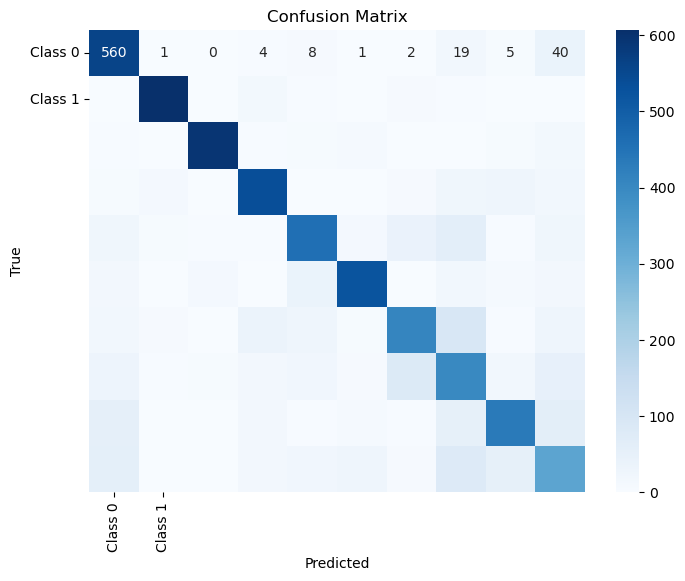

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.88      0.79       640
           1       0.95      0.95      0.95       640
           2       0.96      0.93      0.94       640
           3       0.82      0.84      0.83       640
           4       0.78      0.72      0.75       640
           5       0.87      0.82      0.84       640
           6       0.73      0.64      0.68       640
           7       0.53      0.62      0.57       640
           8       0.77      0.68      0.72       640
           9       0.56      0.55      0.56       600

    accuracy                           0.76      6360
   macro avg       0.77      0.76      0.76      6360
weighted avg       0.77      0.76      0.76      6360

Accuracy: 0.7630503144654088
F1 Score (Weighted): 0.763986229707021
Precision (Weighted): 0.7688378116094885
Recall (Weighted): 0.7630503144654088


In [46]:
y_pred = grid_search.best_estimator_.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting Confusion Matrix using Seaborn Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # You can also use 'micro' or 'macro'
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Print additional metrics
print("Accuracy:", accuracy)
print("F1 Score (Weighted):", f1)
print("Precision (Weighted):", precision)
print("Recall (Weighted):", recall)

----

WITH Feature Selection

In [48]:
scaled_feature_df

,muscle_1_mean,muscle_1_median,muscle_1_rms,muscle_1_mav,muscle_1_wl,muscle_1_zcr,muscle_1_wamp,muscle_1_aac,muscle_1_logd,muscle_1_ssi,...,muscle_4_wavelet_level_5_median,muscle_4_wavelet_level_5_rms,muscle_4_wavelet_level_5_energy,muscle_4_wavelet_level_5_skewness,muscle_4_wavelet_level_5_kurtosis,muscle_4_wavelet_level_5_abs_sum,muscle_4_wavelet_level_5_waveform_length,muscle_4_wavelet_level_5_zcr,activity_id,cycle_id
0,0.100805,0.241741,-0.523714,-0.555462,-0.575160,-1.387945,-0.483318,-0.575160,-0.583335,-1.873412,...,0.254761,-0.387822,-0.129022,-1.677847,0.724180,-0.394237,-0.392708,-1.302238,1,1
1,-0.278511,0.288672,-0.603109,-0.603084,-0.605418,-1.316129,-0.548068,-0.605418,-0.635822,-1.429190,...,-0.066232,-0.412304,-0.129935,-0.926456,0.276363,-0.418631,-0.420780,-1.487977,1,1
2,0.163177,0.132726,-0.560662,-0.548897,-0.583196,-1.028864,-0.627758,-0.583196,-0.574125,-2.156099,...,0.137082,-0.406320,-0.129723,-1.363627,0.525254,-0.419023,-0.414261,-0.868848,1,1
3,-0.094004,0.278250,-0.599177,-0.602704,-0.610939,-1.172496,-0.601944,-0.610939,-0.635541,-1.873412,...,0.067536,-0.447921,-0.131051,-1.459914,0.355679,-0.457940,-0.448245,-0.621197,1,1
4,-0.948367,0.133613,-0.561417,-0.582213,-0.598991,-1.244313,-0.458580,-0.598991,-0.613027,-1.590725,...,-0.039498,-0.441883,-0.130879,-0.650241,0.413017,-0.453682,-0.442122,-0.559284,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31795,-0.177795,-0.427519,-0.407516,-0.401442,-0.346192,0.048376,-0.461882,-0.346192,-0.408886,-0.298441,...,0.006205,-0.507661,-0.132360,-0.436125,-0.339383,-0.503853,-0.492066,1.112364,10,5
31796,0.890999,0.111730,-0.402045,-0.393774,-0.362176,0.515181,-0.481556,-0.362176,-0.400230,-0.258057,...,-0.020314,-0.517099,-0.132502,-0.320129,-0.494367,-0.509381,-0.497409,0.555148,10,5
31797,0.138513,-0.265339,-0.461048,-0.483856,-0.439161,-0.167072,-0.419883,-0.439161,-0.502512,-0.459976,...,-0.059969,-0.505800,-0.132330,-0.190570,-0.547290,-0.496169,-0.486484,0.617061,10,5
31798,0.342851,0.070527,-0.390690,-0.392800,-0.386740,-0.167072,-0.378450,-0.386740,-0.399686,-1.065735,...,-0.057307,-0.508253,-0.132369,0.052723,-0.375921,-0.501987,-0.490144,0.245584,10,5


[CV] END bootstrap=True, class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time= 1.2min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.5min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time= 1.2min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time= 1.2min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time= 1.3min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time= 1.1min
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time= 1.5min
[CV] END bootstrap=T

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# Adjust k to avoid exceeding available feature count
k = 300  # Choose based on experimentation
max_features = scaled_feature_df.drop(columns=["activity_id", "cycle_id"]).shape[1]
k = min(k, max_features)

# Select top k features
selector = SelectKBest(score_func=f_classif, k=k)
X = scaled_feature_df.drop(columns=["activity_id", "cycle_id"])
y = scaled_feature_df["activity_id"]

selected_features = selector.fit_transform(X, y)

# Extract feature names from the support mask
selected_columns = np.array(X.columns)[selector.get_support()]
selected_feature_df = pd.DataFrame(selected_features, columns=selected_columns)

# Add back `activity_id` and `cycle_id`
selected_feature_df["activity_id"] = scaled_feature_df["activity_id"].reset_index(drop=True)
selected_feature_df["cycle_id"] = scaled_feature_df["cycle_id"].reset_index(drop=True)

print("Selected features shape:", selected_feature_df.shape)


Selected features shape: (31800, 302)


In [50]:
# Split data into train and test sets
train_data = selected_feature_df[selected_feature_df['cycle_id'] != 5]
test_data = selected_feature_df[selected_feature_df['cycle_id'] == 5]

# train_data.fillna(train_data.mean(), inplace=True)
print("Missing values in train_data:", train_data.isnull().sum().sum())
print("Missing values in test_data:", test_data.isnull().sum().sum())

Missing values in train_data: 0
Missing values in test_data: 0


In [51]:
X_train = train_data.drop(columns=['activity_id', 'cycle_id'])
y_train = train_data['activity_id']
X_test = test_data.drop(columns=['activity_id', 'cycle_id'])
y_test = test_data['activity_id']

# Output the shapes to confirm the splits
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (25440, 300), y_train shape: (25440,)
X_test shape: (6360, 300), y_test shape: (6360,)


In [52]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [53]:
# Parameters - expanded range of values
param_grid = {
    'bootstrap': [True],  # Try both options for bootstrap
    'max_depth': [20],  # Different depths to try
    'min_samples_leaf': [1, 2],  # Try a range of values for min_samples_leaf
    'min_samples_split': [2, 3],  # Different values for min_samples_split
    'n_estimators': [150, 200],  # Vary the number of trees
    'class_weight': ['balanced']  # Include class_weight for handling imbalanced datasets
}

# Model initialization
model = RandomForestClassifier(random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model with grid search
grid_search.fit(X_train, y_train)  # Make sure X_train and y_train are defined in your dataset

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Hyperparameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.5677672955974843


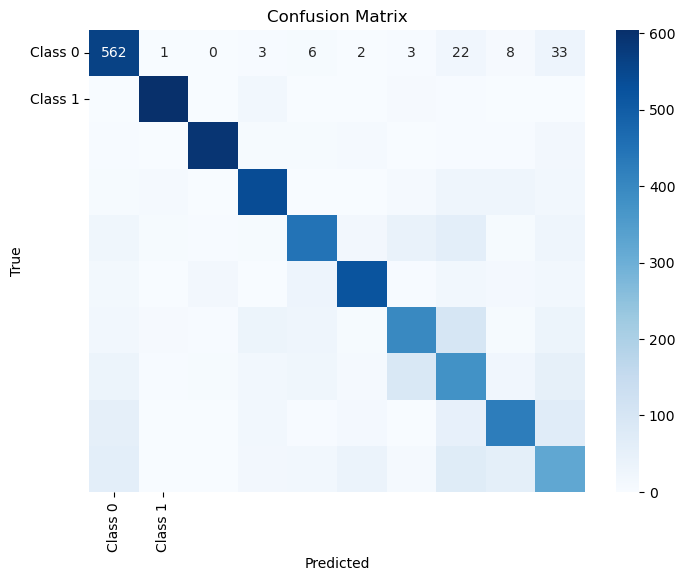

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.88      0.79       640
           1       0.95      0.94      0.95       640
           2       0.95      0.92      0.94       640
           3       0.81      0.84      0.82       640
           4       0.79      0.70      0.74       640
           5       0.85      0.81      0.83       640
           6       0.70      0.62      0.66       640
           7       0.51      0.59      0.55       640
           8       0.75      0.67      0.71       640
           9       0.54      0.54      0.54       600

    accuracy                           0.75      6360
   macro avg       0.76      0.75      0.75      6360
weighted avg       0.76      0.75      0.75      6360

Accuracy: 0.7523584905660378
F1 Score (Weighted): 0.7529176225184886
Precision (Weighted): 0.7571707917111172
Recall (Weighted): 0.7523584905660378
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, min_sam

In [54]:
y_pred = grid_search.best_estimator_.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting Confusion Matrix using Seaborn Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # You can also use 'micro' or 'macro'
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Print additional metrics
print("Accuracy:", accuracy)
print("F1 Score (Weighted):", f1)
print("Precision (Weighted):", precision)
print("Recall (Weighted):", recall)